# **The Navier-Stokes equations**
**Cecilia Rydefalk**

# **Abstract**

In the following report an example on a solution to the Navier-Stokes equation using FEniCS is presented. The velocity and pressure field in a 2D channel with a circular obstacle is studied. A parametric study of drag and lift coefficients and the Strouhal number for different mesh resolutions is performed. 

# **About the code**

In [1]:
"""This program is a lab report in the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# This file is an assignment in the course DD2365 Advanced Computation in Fluid Mechanics
# This report is based on a template provided by Johan Hoffman
# KTH Royal Institute of Technology, Stockholm, Sweden

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 https://developer.downloa

# **Introduction**

The Navier-Stokes equation take the form

$$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,$$
and together with the continuity equation
$$\quad \nabla \cdot u=0,$$
an incompressible flow field with suitable initial and boundary conditions can be described.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$ ![alt text](https://)

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

Three mesh resolutions are used in the computations and results are compared for selected variables.

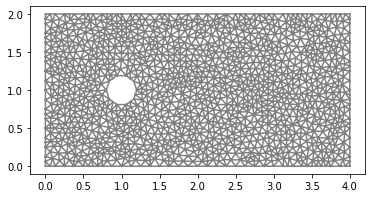

In [3]:
# Define rectangular domain 
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution1 = 8
resolution2 = 16
resolution3 = 32
resolution = resolution3

mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [4]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


**Define boundary conditions**

In [0]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)

uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

The Reynolds number is defined as $\text{Re}=\frac{UD}{\nu}.$ By changing the viscosity so that $\nu = 0.4,\; 0.04,\; 0.004,\; 0.0004$ ($U=1$ and $D=0.4$) the Reynolds number will become $\text{Re}=1,\; 10,\; 100,\; 1000$.

In [0]:
# Set viscosity
nu_Re1 = 0.4
nu_Re10 = 0.04
nu_Re100 = 0.004
nu_Re1000 = 0.0004

nu = nu_Re100

**Define method parameters**

In [0]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() 

**Define variational problem**

In [0]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx 
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

To find the drag and lift on the circle the streamwise and cross-stream forces on the surface are computed. Normalizing the forces gives the drag and lift coefficients 
$$c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}$$
computed and compared for the different mesh resolutions. The weight function plots show the direction of the force on the cylinder. 

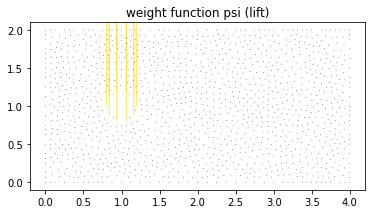

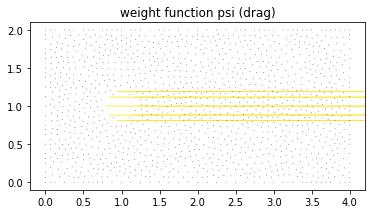

In [9]:
# Define the direction of the force to be computed 
phi_x_drag = 1.0
phi_y_drag = 0.0

phi_x_lift = 0.0
phi_y_lift = 1.0

psi_expression_drag = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x_drag : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y_drag : 0."), xc=xc, yc=yc, rc=rc, phi_x_drag=phi_x_drag, phi_y_drag=phi_y_drag, element = V.ufl_element())
psi_drag = interpolate(psi_expression_drag, V)

psi_expression_lift = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x_lift : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y_lift : 0."), xc=xc, yc=yc, rc=rc, phi_x_lift=phi_x_lift, phi_y_lift=phi_y_lift, element = V.ufl_element())
psi_lift = interpolate(psi_expression_lift, V)

LiftForce = inner((u1 - u0)/dt + grad(um1)*um1, psi_lift)*dx - p1*div(psi_lift)*dx + nu*inner(grad(um1), grad(psi_lift))*dx
DragForce = inner((u1 - u0)/dt + grad(um1)*um1, psi_drag)*dx - p1*div(psi_drag)*dx + nu*inner(grad(um1), grad(psi_drag))*dx

plt.figure()
plot(psi_lift, title="weight function psi (lift)")

plt.figure()
plot(psi_drag, title="weight function psi (drag)")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [0]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data 
force_array_lift = np.array(0.0)
force_array_lift = np.delete(force_array_lift, 0)
force_array_drag = np.array(0.0)
force_array_drag = np.delete(force_array_drag, 0)

time_lift = np.array(0.0)
time_lift = np.delete(time_lift, 0)
time_drag = np.array(0.0)
time_drag = np.delete(time_drag, 0)

start_sample_time = 1.0

**Time stepping algorithm**

The drag and lift forces are normalized and the coefficients are plotted as a function of time. They will oscillate when $Re$ is sufficiently large that vortex shedding is induced. The alternating patterns of the vortex street will result in a $C_L$ that oscillates between a positive and negative value of approximately equal size, while $C_D$ will oscillate between two close values.

The velocity and pressure plots show how the flow around the circular object evolves over time. 

For $\text{Re}=1$ the viscosity dominates over the inertia and the creeping flow is stable around the circle. 

At $\text{Re}=10$ symmetric vortices will form behind the circle, but the flow is still stable. 

At $\text{Re}=100$ alternating vortices form in the wake, a von Karman vortex street. 

At $\text{Re}=1000$ the flow still has a pattern of altarnating vortices as the wake has not become fully turbulent yet. 

All of the results above are consistent with theory. However, this is at the highest mesh resolution. For lowe resolution, the vortex street doesn't form properly and the computed constants deviate from theory. The computed numbers are presented below.

rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.03285506167650246


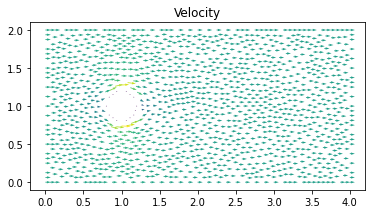

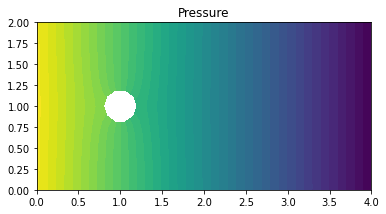

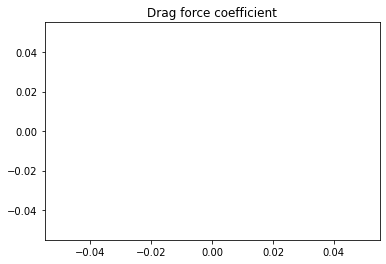

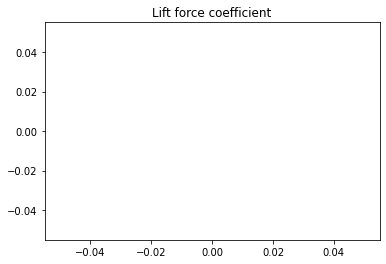

Time t = 3.022665674238231


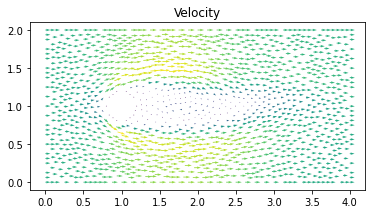

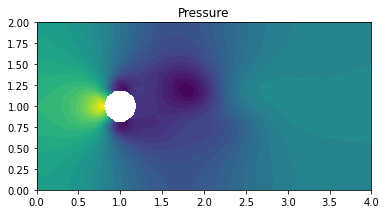

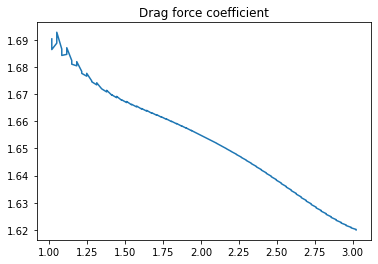

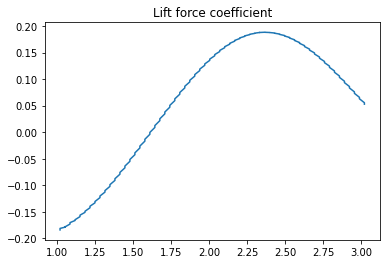

Time t = 6.012476286799972


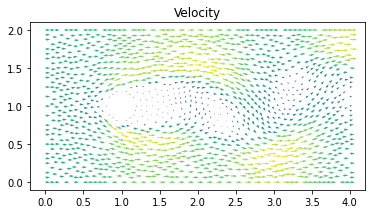

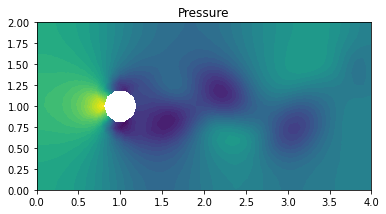

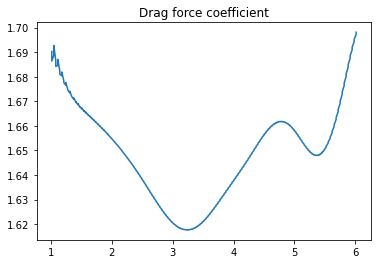

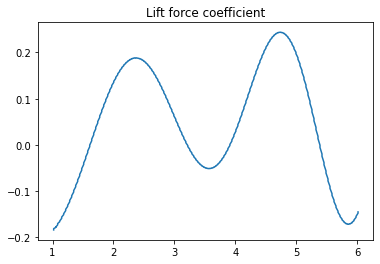

Time t = 9.002286899361685


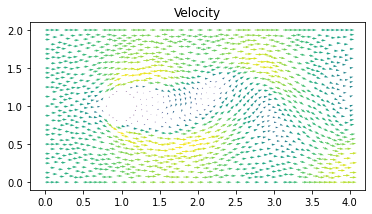

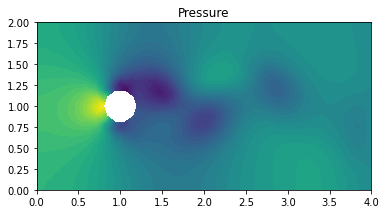

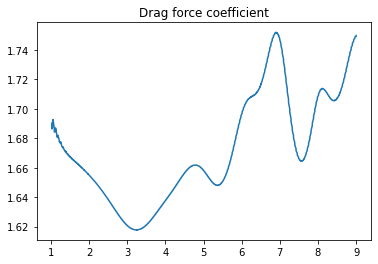

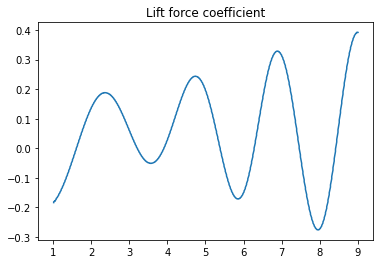

Time t = 12.024952573599847


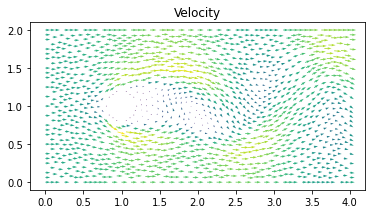

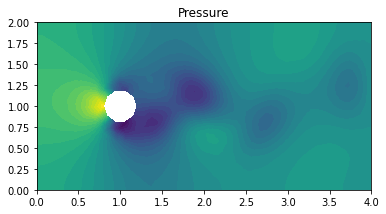

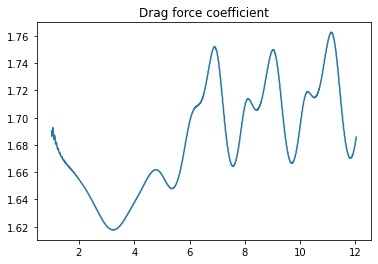

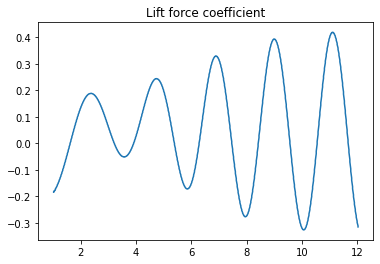

Time t = 15.014763186161508


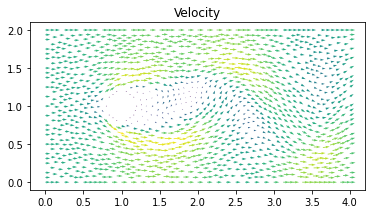

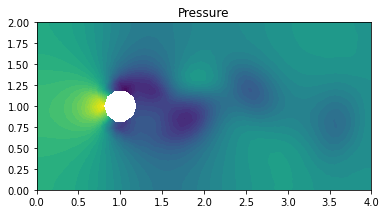

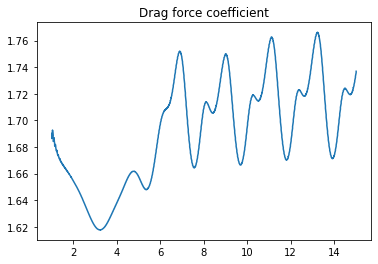

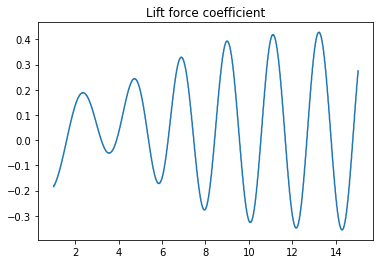

Time t = 18.00457379872328


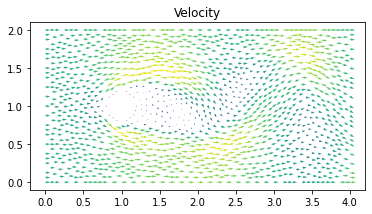

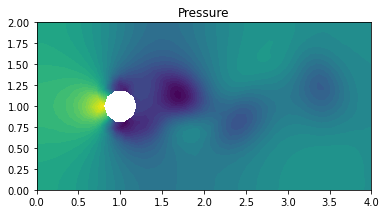

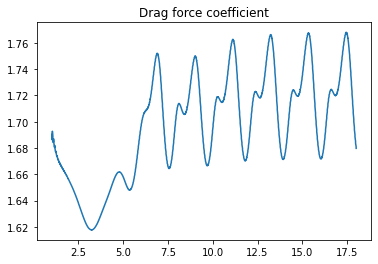

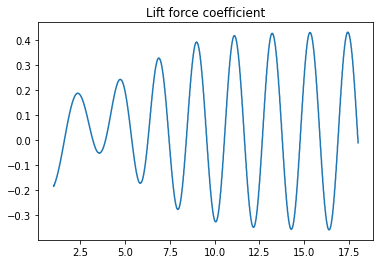

Time t = 21.027239472961604


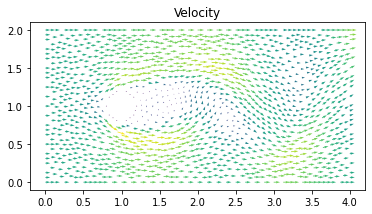

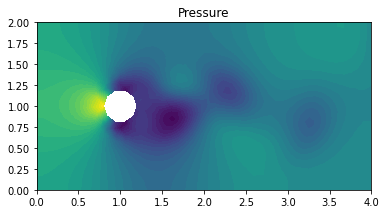

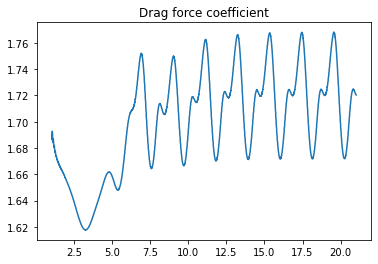

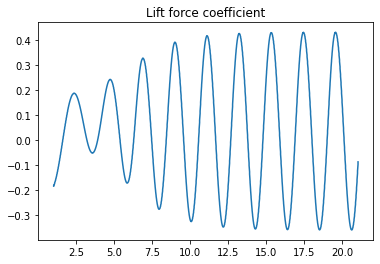

Time t = 24.017050085523426


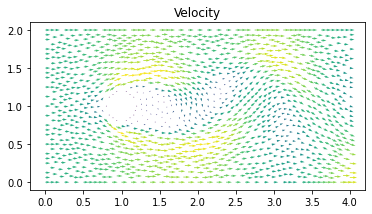

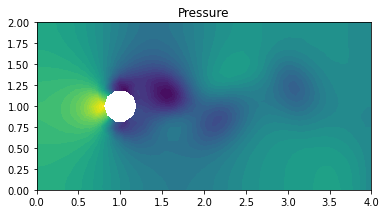

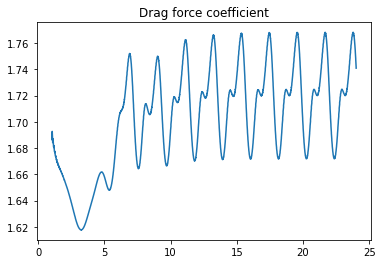

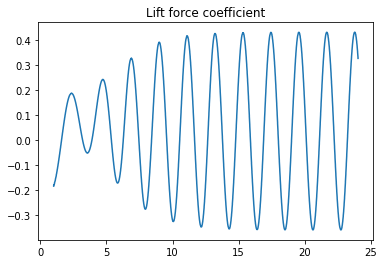

Time t = 27.006860698085248


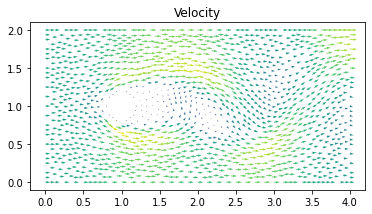

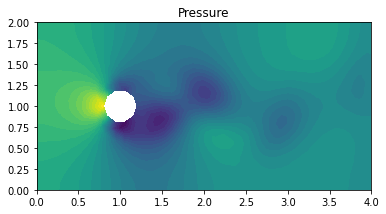

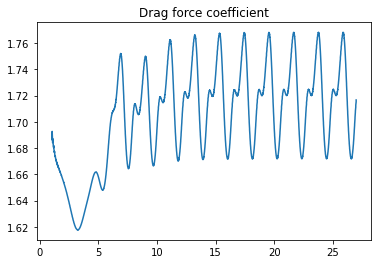

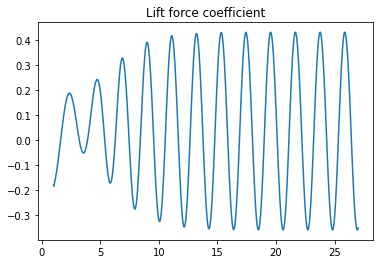

In [11]:
!rm results-NS/*

# Time stepping 
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute drag force
        F_drag = assemble(DragForce)
        if (t > start_sample_time):
          force_array_drag = np.append(force_array_drag, normalization*F_drag)
          time_drag = np.append(time_drag, t)

        # Compute lift force
        F_lift = assemble(LiftForce)
        if (t > start_sample_time):
          force_array_lift = np.append(force_array_lift, normalization*F_lift)
          time_lift = np.append(time_lift, t)


        k += 1

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq
        
        plt.show()

        plt.figure()
        plt.title("Drag force coefficient")
        plt.plot(time_drag, force_array_drag)
        plt.show()

        plt.figure()
        plt.title("Lift force coefficient")
        plt.plot(time_lift, force_array_lift)
        plt.show()


    # Update time step
    u0.assign(u1)
    t += dt



In [0]:
#!tar -czvf results-NS.tar.gz results-NS


In [0]:
#files.download('results-NS.tar.gz')

**Parameter study at Re=100**

Comparison of the solution for $\text{Re}=100$ under the different mesh resolutions h=1/8, 1/16, 1/32. 

*   $C_D$
1.   Resolution 1/8: $\approx 2.98$
2.   Resolution 1/16: $\approx 2.9$
3.   Resolution 1/32: $\approx 1.66-1.76$

*   $C_L$
1.   Resolution 1/8: $-0.06$
2.   Resolution 1/16: $\pm 0.2$
3.   Resolution 1/32: $\pm 0.4$
*   St 
1.   Resolution 1/8: Resolution too poor, no vortex shedding
2.   Resolution 1/16: $\approx 0.17$
3.   Resolution 1/32: $\approx 0.19$












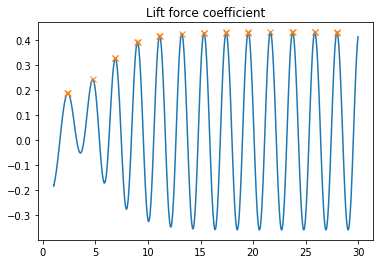

0.19324895541885456


In [13]:
#Strouhal number
from scipy.signal import find_peaks

if nu == nu_Re100:
  peaks_lift, _ = find_peaks(force_array_lift, height=0)
  plt.figure()
  plt.title("Lift force coefficient")
  plt.plot(time_lift, force_array_lift)
  plt.plot(time_lift[peaks_lift],force_array_lift[peaks_lift], "x")
  plt.show()
  frequency_lift = 1 / (time_lift[peaks_lift[-2]] - time_lift[peaks_lift[-3]])
  St_lift = D * frequency_lift / uin 
  print(St_lift)

  

# **Discussion**

*A* stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D for the flow past a cylinder. At the highest mesh resolution used the solution behaves as expected and e.g. at $\text{Re}=100$ a von Karman vortex street is formed in the wake. However, at lower resolution the computed coefficients, the Strouhal number and the wake deviates from theory.